## Settings

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [87]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import *

from numba import jit

In [3]:
if not 'covid' in os.listdir():
    sys.path.append('..')
    
import covid

## Loading

In [4]:
from covid.dataset import fetch_daily_case

In [118]:
data = fetch_daily_case(update=True, return_data=True)

data = (
    data
    .query('source_nom == "Ministère des Solidarités et de la Santé"')
    .query('granularite == "pays"')
    .filter(['date', 'cas_confirmes', 'hospitalises', 'gueris', 'deces'])
    .assign(date=lambda x: pd.to_datetime(x['date']))
    .set_index('date')
)

start_date = data.index.min()
end_date = pd.to_datetime('2020-03-20')

dates = pd.date_range(start_date, end_date)

data['gueris'] = data['gueris'].interpolate().fillna(0)
data['cas_confirmes'] = data['cas_confirmes'].interpolate().fillna(0)
data['hospitalises'] = data['hospitalises'].interpolate().fillna(0)
data['deces'] = data['deces'].interpolate().fillna(0)

print(start_date, end_date)

2020-01-24 00:00:00 2020-03-20 00:00:00


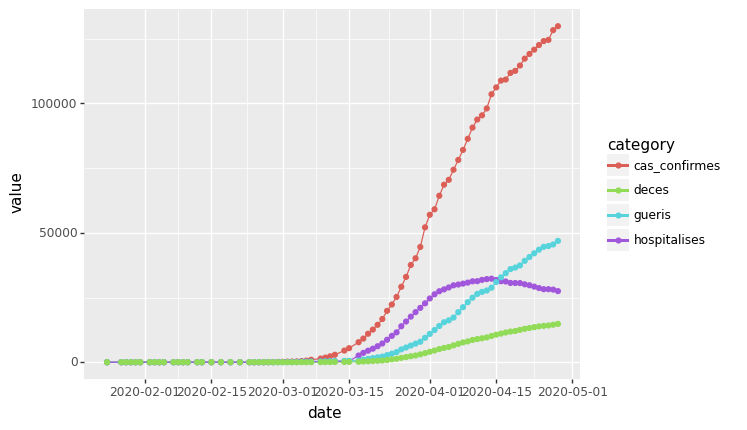

<ggplot: (-9223371851849012976)>

In [119]:
data_ = (
    data
    .reset_index()
    .melt(id_vars=['date'], var_name='category', value_name='value')
)

(
    ggplot(data_)
    + aes(x='date', y='value', color='category')
    + geom_line()
    + geom_point()
)

## Model

### Prior knowledge

Optimization with hyperopt / scipy.optimize.differential_solution to get a knowledge about parameters.

In [120]:
from covid.models import SIR

In [121]:
N = int(6.5e7)
I0 = 2
init_state = (N-I0, I0, 0)

gamma_0 = 1/4
R0 = 5
beta_0 = gamma_0 * R0

params_0 = (beta_0, gamma_0)

In [122]:
def solve_sir(params):
    
    beta, gamma = params

    model = SIR(N, beta, gamma)
    res = model.solve(init_state, start_date=start_date)
    
    s_pred = res.loc[dates]['S']
    r_pred = res.loc[dates]['R']
    i_pred = res.loc[dates]['I']
    
    return i_pred

In [123]:
%%time
i_pred_0 = solve_sir(params_0)

Wall time: 344 ms


In [124]:
def sse(params):
    i_pred = solve_sir(params)
    sse = np.sum((i_pred-data['cas_confirmes'])**2)
    return sse

In [125]:
%%time
print("SSE:", sse(params_0))

SSE: 3179624683642770.0
Wall time: 378 ms


In [126]:
from scipy.optimize import minimize

In [136]:
bounds = [(0.5,2), (0.2,1)]

In [140]:
%%time
msol = minimize(
    fun=sse,
    x0=[beta_0,gamma_0],
#     bounds=bounds,
    options={'disp': True})
print(msol)

         Current function value: 6745983.508202
         Iterations: 33
         Function evaluations: 539
         Gradient evaluations: 132
      fun: 6745983.508201934
 hess_inv: array([[2.81787868e-06, 2.81801960e-06],
       [2.81801960e-06, 2.81816088e-06]])
      jac: array([-14342087.125 ,  14347580.1875])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 539
      nit: 33
     njev: 132
   status: 2
  success: False
        x: array([-0.13925226, -0.29488409])
Wall time: 1min 30s


In [141]:
sol = solve_sir(msol.x)

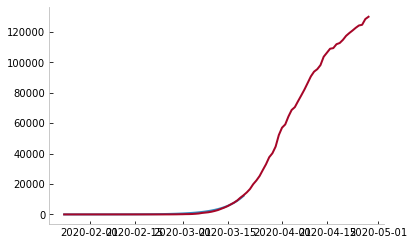

In [142]:
plt.plot(sol)
plt.plot(data['cas_confirmes'])

### Posterior

In [20]:
sys.path.append(r"C:\Program Files (x86)\mingw-w64\i686-8.1.0-posix-dwarf-rt_v6-rev0\mingw32\bin")
import theano
import theano.tensor as t
import pymc3 as pm

In [23]:
@theano.compile.ops.as_op(itypes=[t.dscalar,t.dscalar], otypes=[t.dvector])
def solve_sir_wrap(beta, gamma):
    model = SIR(N, beta, gamma)
    res = model.solve(init_state, start_date=start_date)
    i_pred = res.loc[dates]['I']
    return np.array(i_pred)

In [29]:
with pm.Model() as model:
       
    beta = pm.Uniform('beta', lower=0.5, upper=1.5)
    gamma = pm.Uniform('gamma', lower=0.5, upper=1.5)

    fitting_model = pm.Deterministic('sir', solve_sir_wrap(beta, gamma))

    # Variance related to population fraction amount! Let's assume a variance of 100 individuals, since there are cases that have been not tracked
    variance = 100
    standard_deviation = np.sqrt(variance)
    likelihood_model = pm.Normal(
        'likelihood_model', 
        mu=fitting_model, 
        sd=10, 
        observed=data['cas_confirmes']
    )

    # The Monte Carlo procedure driver
    step = pm.step_methods.Metropolis()
    sir_trace = pm.sample(cores=1, step=step)

Sampling chain 1, 0 divergences: 100%|█████████████████████████████████████████████| 1000/1000 [10:33<00:00,  1.58it/s]
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
